In [33]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
os.environ['TORCH_HOME'] = "/media/hdd/Datasets/"
import sys
sys.path.append("/media/hdd/github/sprintdl/")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from sprintdl.main import *
import sprintdl

In [3]:
device = torch.device('cuda',0)
from torch.nn import init
import torch
import math

In [4]:
from sprintdl.models.xresnet import *

# Define required

In [5]:
fpath = Path("/media/hdd/Datasets/face_age/")

train_transform = [A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
#         A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
#         A.RandomBrightnessContrast(p=0.5),
    ]

tfms = [ATransform(train_transform, c_in = 3)]
bs = 128

# Actual process

In [10]:
il = ImageList.from_files(fpath, tfms=tfms)

In [11]:
il

ImageList (9778 items)
[PosixPath('/media/hdd/Datasets/face_age/93/2342.png'), PosixPath('/media/hdd/Datasets/face_age/93/6681.png'), PosixPath('/media/hdd/Datasets/face_age/93/1233.png'), PosixPath('/media/hdd/Datasets/face_age/1/6285.png'), PosixPath('/media/hdd/Datasets/face_age/1/1963.png'), PosixPath('/media/hdd/Datasets/face_age/1/2184.png'), PosixPath('/media/hdd/Datasets/face_age/1/8067.png'), PosixPath('/media/hdd/Datasets/face_age/1/7729.png'), PosixPath('/media/hdd/Datasets/face_age/1/1792.png'), PosixPath('/media/hdd/Datasets/face_age/1/6264.png')...]
Path: /media/hdd/Datasets/face_age

In [12]:
sd = SplitData.split_by_func(il, partial(random_splitter, p_valid = .2))
ll = label_by_func(sd, lambda x: str(x).split("/")[-2], proc_y=CategoryProcessor())

In [13]:
n_classes = len(set(ll.train.y.items))

In [14]:
n_classes

99

In [15]:
data = ll.to_databunch(bs, c_in=3, c_out=n_classes)

In [16]:
data.train_ds.y

ItemList (7923 items)
[0, 0, 1, 1, 1, 1, 1, 1, 1, 1...]
Path: /media/hdd/Datasets/face_age

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


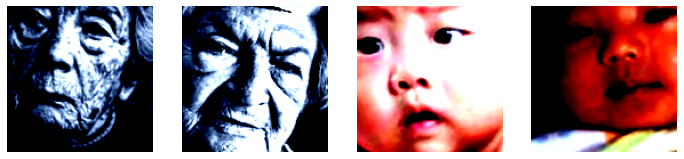

In [17]:
show_batch(data, 4)

# Training

In [18]:
def mseloss(input, target):
    return nn.MSELoss()(input, target.type(torch.FloatTensor).cuda())

In [19]:
lr = .001
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))

cbfs = [
    partial(AvgStatsCallback,[accuracy, mseloss]),
    partial(ParamScheduler, 'lr', sched_lr),
    partial(ParamScheduler, 'mom', sched_mom),
        partial(BatchTransformXCallback, norm_imagenette),
    ProgressCallback,
    Recorder,
#     MixUp,
       partial(CudaCallback, device)]

# loss_func=LabelSmoothingCrossEntropy()
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

In [20]:
arch = partial(xresnet34, c_out =1)()

In [25]:
learn = Learner(arch, data,mseloss, lr=lr, cb_funcs=cbfs, opt_func=opt_func)

In [26]:
learn.fit(10)

epoch,train_loss,train_accuracy,train_mseloss,valid_loss,valid_accuracy,valid_mseloss,time
0,2586.066641,0.000252,2586.066650,2497.422642,0.000539,2497.422607,00:14
1,2176.211284,0.000252,2176.211182,1976.604582,0.000539,1976.604614,00:15
2,1595.377887,0.000252,1595.377808,1375.766577,0.000539,1375.766602,00:15
3,1040.692667,0.000252,1040.692627,967.111119,0.000539,967.111145,00:15
4,902.653793,0.000252,902.653748,924.493329,0.000539,924.493347,00:15
5,901.432791,0.000252,901.432739,945.120553,0.000539,945.120544,00:15
6,900.974000,0.000252,900.973999,929.669677,0.000539,929.669678,00:15
7,901.084564,0.000252,901.084534,929.888679,0.000539,929.888672,00:15
8,901.198410,0.000252,901.198364,930.837399,0.000539,930.837402,00:15
9,900.815663,0.000252,900.815613,930.750135,0.000539,930.750122,00:15


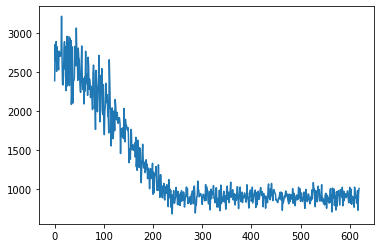

In [31]:
learn.recorder.plot_loss()

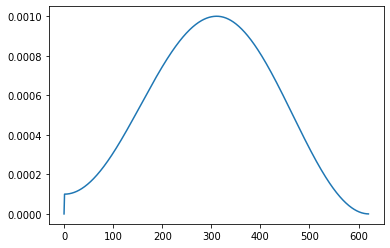

In [32]:
learn.recorder.plot_lr()